In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [137]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_ds = load_diabetes()

print(diabetes_ds["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [138]:
# Save the input and target variables

X, Y = diabetes_ds["data"], diabetes_ds["target"]

In [139]:
# Normalise the target data (this will make clearer training curves)

X_std = (X - X.mean(axis=0)) / X.std(axis=0)

In [140]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.33, random_state=42)

#### Train a feedforward neural network model

In [141]:
X_train.shape

(296, 10)

In [142]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses, metrics

def get_unregularised_model():
  model = Sequential([
                    layers.InputLayer(input_shape=(10,)),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=128, activation="relu"),
                    layers.Dense(units=1)
          ])
  
  return model

In [143]:
# Print the model summary

model = get_unregularised_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_93 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_94 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_95 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_96 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_97 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_98 (Dense)             (None, 1)               

In [144]:
# Compile the model

model.compile(optimizer="adam", 
              loss=losses.MeanSquaredLogarithmicError(), 
              metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError()])

In [145]:
# Train the model, with some of the data reserved for validation

history = model.fit(x = X_train, 
                    y = y_train, 
                    batch_size = 10, 
                    epochs = 50,
                    validation_split = 0.2,
                    verbose = 2)

Epoch 1/50
24/24 - 0s - loss: 19.0530 - mean_absolute_error: 154.3551 - mean_squared_error: 30026.8301 - val_loss: 5.6662 - val_mean_absolute_error: 124.8872 - val_mean_squared_error: 20464.3750
Epoch 2/50
24/24 - 0s - loss: 1.5468 - mean_absolute_error: 94.9943 - mean_squared_error: 14135.1738 - val_loss: 0.4146 - val_mean_absolute_error: 72.4768 - val_mean_squared_error: 7476.6538
Epoch 3/50
24/24 - 0s - loss: 0.4015 - mean_absolute_error: 74.9196 - mean_squared_error: 9117.1025 - val_loss: 0.2386 - val_mean_absolute_error: 50.1277 - val_mean_squared_error: 4002.9775
Epoch 4/50
24/24 - 0s - loss: 0.2518 - mean_absolute_error: 56.9933 - mean_squared_error: 5157.6528 - val_loss: 0.2083 - val_mean_absolute_error: 47.1994 - val_mean_squared_error: 3911.6626
Epoch 5/50
24/24 - 0s - loss: 0.2297 - mean_absolute_error: 54.1168 - mean_squared_error: 4685.9526 - val_loss: 0.1888 - val_mean_absolute_error: 45.1019 - val_mean_squared_error: 3453.3521
Epoch 6/50
24/24 - 0s - loss: 0.2134 - mean_

In [146]:
# Evaluate the model on the test set

_ = model.evaluate(
                    x = X_test, 
                    y = y_test, 
                    verbose=2
                  )

5/5 - 0s - loss: 0.2108 - mean_absolute_error: 46.7213 - mean_squared_error: 3642.3811


#### Plot the learning curves

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

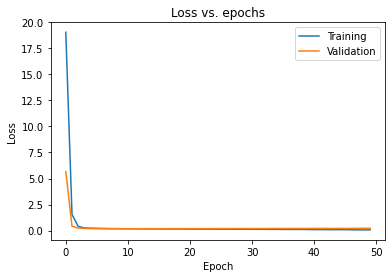

In [148]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [149]:
from tensorflow.keras import regularizers

In [150]:
def get_regularised_model(wd, rate):
    model = Sequential([
        layers.InputLayer(input_shape=(X_train.shape[1],)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        layers.Dropout(rate=rate),
        layers.Dense(1)
    ])
    return model

In [151]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 128)               512       
_________________________________________________________________
dense_101 (Dense)            (None, 128)             

In [152]:
# Compile the model

model.compile(optimizer="adam", 
              loss = losses.MeanSquaredLogarithmicError(), 
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])

In [153]:
# Train the model, with some of the data reserved for validation

history = model.fit(x = X_train, 
                    y = y_train, 
                    batch_size = 10, 
                    epochs = 50,
                    validation_split = 0.2,
                    verbose = 2)

Epoch 1/50
24/24 - 0s - loss: 19.0911 - mean_squared_error: 30262.4355 - mean_absolute_error: 155.1036 - val_loss: 19.2614 - val_mean_squared_error: 23317.6328 - val_mean_absolute_error: 135.5634
Epoch 2/50
24/24 - 0s - loss: 14.2829 - mean_squared_error: 29798.2773 - mean_absolute_error: 153.5329 - val_loss: 15.6696 - val_mean_squared_error: 23090.9258 - val_mean_absolute_error: 134.7315
Epoch 3/50
24/24 - 0s - loss: 11.9230 - mean_squared_error: 29386.3652 - mean_absolute_error: 152.2345 - val_loss: 13.1747 - val_mean_squared_error: 22838.4805 - val_mean_absolute_error: 133.8002
Epoch 4/50
24/24 - 0s - loss: 10.1541 - mean_squared_error: 28966.9355 - mean_absolute_error: 150.8382 - val_loss: 11.2806 - val_mean_squared_error: 22559.7676 - val_mean_absolute_error: 132.7577
Epoch 5/50
24/24 - 0s - loss: 9.0475 - mean_squared_error: 28593.9453 - mean_absolute_error: 149.6579 - val_loss: 9.6599 - val_mean_squared_error: 22228.5742 - val_mean_absolute_error: 131.4958
Epoch 6/50
24/24 - 0s 

In [154]:
# Evaluate the model on the test set

_ = model.evaluate(
                    x = X_test, 
                    y = y_test, 
                    verbose=2
                  )

5/5 - 0s - loss: 0.1886 - mean_squared_error: 3249.0042 - mean_absolute_error: 45.2757


#### Plot the learning curves

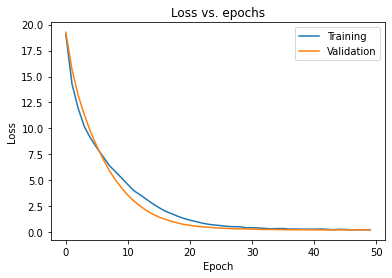

In [155]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [156]:
# Write a custom callback
from tensorflow.keras import callbacks

class TrainingCallback(callbacks.Callback):

    def on_train_begin(self, logs=None):
        print("Initiating Training ...")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Initiating Epoch: {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Initiating Training for Batch: {batch}")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training Completes for Batch: {batch}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"{epoch} Epoch Completes")

    def on_train_end(self, logs=None):
        print("Training Completes")


class TestingCallback(callbacks.Callback):

    def on_test_begin(self, logs=None):
        print("Initiating Testing ...")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Initiating Testing for Batch: {batch}")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing Completes for Batch: {batch}")

    def on_test_end(self, logs=None):
        print("Testing Completes")


class PredictionCallback(callbacks.Callback):

    def on_predict_begin(self, logs=None):
        print("Initiating Prediction ...")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction Testing for Batch: {batch}")
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction Completes for Batch: {batch}")

    def on_predict_end(self, logs=None):
        print("Prediction Completes")

In [157]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 128)               1408      
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 128)               512       
_________________________________________________________________
dense_107 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
dense_108 (Dense)            (None, 128)             

In [158]:
# Compile the model

model.compile(optimizer="adam", 
              loss = losses.MeanSquaredLogarithmicError(), 
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])

#### Train the model with the callback

In [159]:
# Train the model, with some of the data reserved for validation

history = model.fit(x = X_train, 
                    y = y_train, 
                    batch_size = 100, 
                    epochs = 5,
                    verbose = False,
                    callbacks = [TrainingCallback()])

Initiating Training ...
Initiating Epoch: 0
Initiating Training for Batch: 0
Training Completes for Batch: 0
Initiating Training for Batch: 1
Training Completes for Batch: 1
Initiating Training for Batch: 2
Training Completes for Batch: 2
0 Epoch Completes
Initiating Epoch: 1
Initiating Training for Batch: 0
Training Completes for Batch: 0
Initiating Training for Batch: 1
Training Completes for Batch: 1
Initiating Training for Batch: 2
Training Completes for Batch: 2
1 Epoch Completes
Initiating Epoch: 2
Initiating Training for Batch: 0
Training Completes for Batch: 0
Initiating Training for Batch: 1
Training Completes for Batch: 1
Initiating Training for Batch: 2
Training Completes for Batch: 2
2 Epoch Completes
Initiating Epoch: 3
Initiating Training for Batch: 0
Training Completes for Batch: 0
Initiating Training for Batch: 1
Training Completes for Batch: 1
Initiating Training for Batch: 2
Training Completes for Batch: 2
3 Epoch Completes
Initiating Epoch: 4
Initiating Training for 

In [160]:
# Evaluate the model

model.evaluate(X_test, 
               y_test, 
               verbose=False, 
               callbacks=[TestingCallback()])

Initiating Testing ...
Initiating Testing for Batch: 0
Testing Completes for Batch: 0
Initiating Testing for Batch: 1
Testing Completes for Batch: 1
Initiating Testing for Batch: 2
Testing Completes for Batch: 2
Initiating Testing for Batch: 3
Testing Completes for Batch: 3
Initiating Testing for Batch: 4
Testing Completes for Batch: 4
Testing Completes


[21.438451766967773, 28883.97265625, 152.08676147460938]

In [161]:
# Make predictions with the model

y_pred = model.predict(X_test, batch_size=32, verbose=False, callbacks=[PredictionCallback()])

Initiating Prediction ...
Prediction Testing for Batch: 0
Prediction Completes for Batch: 0
Prediction Testing for Batch: 1
Prediction Completes for Batch: 1
Prediction Testing for Batch: 2
Prediction Completes for Batch: 2
Prediction Testing for Batch: 3
Prediction Completes for Batch: 3
Prediction Testing for Batch: 4
Prediction Completes for Batch: 4
Prediction Completes


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [169]:
# Re-train the unregularised model

unreg_model = get_unregularised_model()

unreg_model.compile(optimizer="adam", 
              loss = losses.MeanSquaredLogarithmicError(), 
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])

unreg_history = unreg_model.fit(x = X_train, 
                    y = y_train, 
                    batch_size = 32, 
                    epochs = 100,
                    validation_split = 0.2,
                    verbose = 2,
                    callbacks = [callbacks.EarlyStopping(patience=5)])

Epoch 1/100
8/8 - 0s - loss: 20.5088 - mean_squared_error: 30350.7148 - mean_absolute_error: 155.4008 - val_loss: 13.4027 - val_mean_squared_error: 22832.4766 - val_mean_absolute_error: 133.8434
Epoch 2/100
8/8 - 0s - loss: 9.5587 - mean_squared_error: 28364.2520 - mean_absolute_error: 149.1916 - val_loss: 3.8652 - val_mean_squared_error: 18810.9590 - val_mean_absolute_error: 118.2742
Epoch 3/100
8/8 - 0s - loss: 2.3043 - mean_squared_error: 20066.1816 - mean_absolute_error: 118.6902 - val_loss: 0.5324 - val_mean_squared_error: 8434.9902 - val_mean_absolute_error: 69.7031
Epoch 4/100
8/8 - 0s - loss: 0.4253 - mean_squared_error: 8044.0044 - mean_absolute_error: 72.3418 - val_loss: 0.3695 - val_mean_squared_error: 6414.8696 - val_mean_absolute_error: 63.9684
Epoch 5/100
8/8 - 0s - loss: 0.4672 - mean_squared_error: 10791.4463 - mean_absolute_error: 82.0473 - val_loss: 0.5317 - val_mean_squared_error: 10851.6436 - val_mean_absolute_error: 85.8634
Epoch 6/100
8/8 - 0s - loss: 0.5012 - mea

In [170]:
# Evaluate the model on the test set

unreg_model.evaluate( X_test, 
                      y_test, 
                      verbose=2)

5/5 - 0s - loss: 0.1739 - mean_squared_error: 3414.4175 - mean_absolute_error: 45.7017


[0.17387999594211578, 3414.41748046875, 45.70167541503906]

In [167]:
# Re-train the regularised model

reg_model = get_regularised_model(1e-5, 0.3)

reg_model.compile(optimizer="adam", 
              loss = losses.MeanSquaredLogarithmicError(), 
              metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError()])

reg_history = reg_model.fit(x = X_train, 
                    y = y_train, 
                    batch_size = 32, 
                    epochs = 100,
                    validation_split = 0.2,
                    verbose = 2,
                    callbacks = [callbacks.EarlyStopping(patience=5)])

Epoch 1/100
8/8 - 0s - loss: 23.4343 - mean_squared_error: 30804.6270 - mean_absolute_error: 156.7377 - val_loss: 22.6618 - val_mean_squared_error: 23448.8633 - val_mean_absolute_error: 136.0473
Epoch 2/100
8/8 - 0s - loss: 22.2118 - mean_squared_error: 30588.5742 - mean_absolute_error: 156.2054 - val_loss: 20.8345 - val_mean_squared_error: 23385.3887 - val_mean_absolute_error: 135.8110
Epoch 3/100
8/8 - 0s - loss: 20.1339 - mean_squared_error: 30410.2090 - mean_absolute_error: 155.5984 - val_loss: 18.6185 - val_mean_squared_error: 23284.2520 - val_mean_absolute_error: 135.4430
Epoch 4/100
8/8 - 0s - loss: 18.1882 - mean_squared_error: 30211.1094 - mean_absolute_error: 154.8560 - val_loss: 16.5597 - val_mean_squared_error: 23155.0039 - val_mean_absolute_error: 134.9795
Epoch 5/100
8/8 - 0s - loss: 16.3310 - mean_squared_error: 29964.4160 - mean_absolute_error: 154.1920 - val_loss: 14.7949 - val_mean_squared_error: 23005.1133 - val_mean_absolute_error: 134.4445
Epoch 6/100
8/8 - 0s - lo

In [168]:
# Evaluate the model on the test set

reg_model.evaluate(X_test, 
               y_test, 
               verbose=2)

5/5 - 0s - loss: 0.2699 - mean_squared_error: 5776.4570 - mean_absolute_error: 61.2493


[0.2698761820793152, 5776.45703125, 61.249324798583984]

#### Plot the learning curves

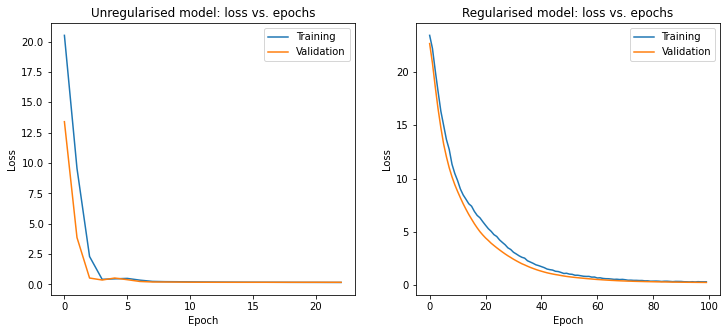

In [171]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()